In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

alcohol_df = pd.read_csv('/content/alcohol-2014-01-01-2024-10-13.csv')
marijuana_df = pd.read_csv('/content/marijuana-2014-01-01-2024-10-13.csv')

# combine year, month, and day into one column
alcohol_df['date'] = pd.to_datetime(alcohol_df[['year', 'month', 'day']])
marijuana_df['date'] = pd.to_datetime(marijuana_df[['year', 'month', 'day']])

# combine both datasets
combined_df = pd.concat([marijuana_df, alcohol_df], ignore_index=True)
combined_df.dropna(inplace=True)  # Ensure no missing values

alcohol_df['type'] = 'alcohol'
marijuana_df['type'] = 'marijuana'

# one hot encode categorical features
combined_df = pd.get_dummies(combined_df, columns=['region_code'], drop_first=True)
combined_df = pd.get_dummies(combined_df, columns=['search'], drop_first=False)

combined_df.dropna(inplace=True)

# split training data based on date
train_df = combined_df[combined_df['date'] < '2023-01-01']
eval_df = combined_df[combined_df['date'] >= '2023-01-01']

X_train = train_df.drop(columns=['value', 'date'])  # Features
y_train = train_df['value']  # Target variable (interest level)
X_eval = eval_df.drop(columns=['value', 'date'])
y_eval = eval_df['value']

X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

((335274, 55), (335274,), (66402, 55), (66402,))

In [ ]:
print(alcohol_df.head())

   year  month  day   search region_code  value       date     type
0  2014      1    1  Alcohol       US-AK     60 2014-01-01  alcohol
1  2014      1    1  Alcohol       US-AL     38 2014-01-01  alcohol
2  2014      1    1  Alcohol       US-AR     59 2014-01-01  alcohol
3  2014      1    1  Alcohol       US-AZ     50 2014-01-01  alcohol
4  2014      1    1  Alcohol       US-CA     55 2014-01-01  alcohol


In [ ]:
print(combined_df.head)


<bound method NDFrame.head of         year  month  day  value       date  region_code_US-AL  \
0       2014      1    1      0 2014-01-01              False   
1       2014      1    1      8 2014-01-01               True   
2       2014      1    1      0 2014-01-01              False   
3       2014      1    1     12 2014-01-01              False   
4       2014      1    1     11 2014-01-01              False   
...      ...    ...  ...    ...        ...                ...   
401671  2024     10   12     77 2024-10-12              False   
401672  2024     10   12     83 2024-10-12              False   
401673  2024     10   12     82 2024-10-12              False   
401674  2024     10   12     80 2024-10-12              False   
401675  2024     10   12     90 2024-10-12              False   

        region_code_US-AR  region_code_US-AZ  region_code_US-CA  \
0                   False              False              False   
1                   False              False           

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_eval)

# loss functions
mse = mean_squared_error(y_eval, y_pred)
mae = mean_absolute_error(y_eval, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_eval, y_pred)

print(f"MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")

MSE: 506.8480632315292, MAE: 15.505583114966418, RMSE: 22.5132863711971, R-squared: 0.25751352905416547


In [ ]:
eval_df['predictions'] = y_pred

# evaluation loss function results for each state
for region in eval_df.filter(like='region_code_').columns:
    state_data = eval_df[eval_df[region] == 1]
    state_mse = mean_squared_error(state_data['value'], state_data['predictions'])
    state_mae = mean_absolute_error(state_data['value'], state_data['predictions'])
    state_rmse = np.sqrt(state_mse)
    print(f"State: {region} -> MSE: {state_mse}, MAE: {state_mae}, RMSE: {state_rmse}")

# Reminder: lower values of MSE, MAE, and RMSE indicate better model accuracy.

State: region_code_US-AL -> MSE: 204.15101497695852, MAE: 11.23811827956989, RMSE: 14.288142460689512
State: region_code_US-AR -> MSE: 444.7965221198157, MAE: 16.373701996927803, RMSE: 21.090199669984532
State: region_code_US-AZ -> MSE: 224.70776305683563, MAE: 12.025906298003072, RMSE: 14.990255603452384
State: region_code_US-CA -> MSE: 99.08507465437788, MAE: 7.8926881720430115, RMSE: 9.954148615244694
State: region_code_US-CO -> MSE: 248.58780437788016, MAE: 12.388963133640551, RMSE: 15.766667510221687
State: region_code_US-CT -> MSE: 273.8128382488479, MAE: 12.992611367127497, RMSE: 16.547290964047498
State: region_code_US-DC -> MSE: 595.5973402457757, MAE: 16.510322580645163, RMSE: 24.40486304501166
State: region_code_US-DE -> MSE: 1163.8799077572965, MAE: 25.00705837173579, RMSE: 34.11568419008032
State: region_code_US-FL -> MSE: 214.87191597542244, MAE: 11.489431643625192, RMSE: 14.658510018941982
State: region_code_US-GA -> MSE: 130.92697941628265, MAE: 8.962227342549923, RMSE:

<ipython-input-4-9e46ddbe1098>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['predictions'] = y_pred


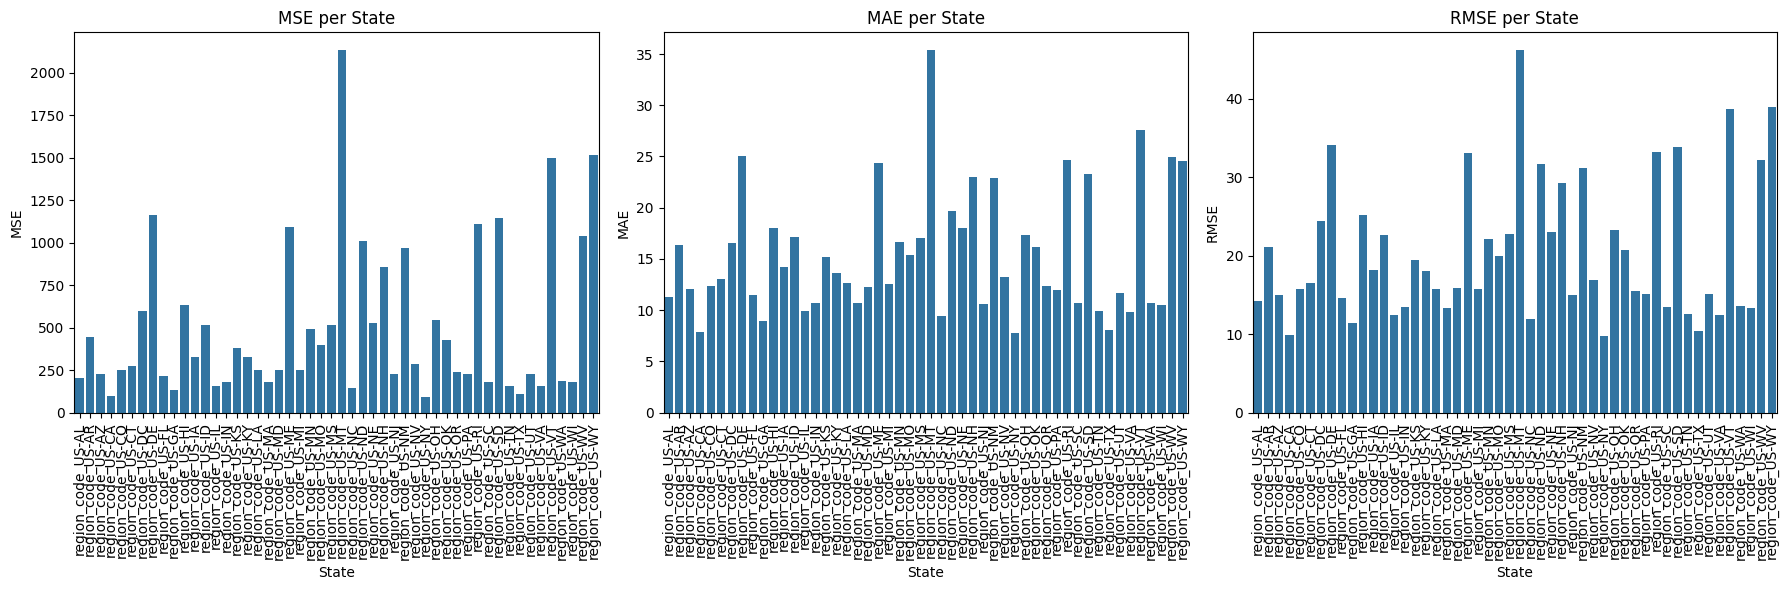

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

states_metrics = []
for region in eval_df.filter(like='region_code_').columns:
    state_data = eval_df[eval_df[region] == 1]
    state_mse = mean_squared_error(state_data['value'], state_data['predictions'])
    state_mae = mean_absolute_error(state_data['value'], state_data['predictions'])
    state_rmse = np.sqrt(state_mse)
    states_metrics.append([region, state_mse, state_mae, state_rmse])

metrics_df = pd.DataFrame(states_metrics, columns=['State', 'MSE', 'MAE', 'RMSE'])

metrics_df.set_index('State', inplace=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# plot mean squared error
sns.barplot(x=metrics_df.index, y='MSE', data=metrics_df, ax=ax[0])
ax[0].set_title('MSE per State')
ax[0].set_ylabel('MSE')
ax[0].tick_params(axis='x', rotation=90) # vertical x-axis labels

# plot mean absolute error
sns.barplot(x=metrics_df.index, y='MAE', data=metrics_df, ax=ax[1])
ax[1].set_title('MAE per State')
ax[1].set_ylabel('MAE')
ax[1].tick_params(axis='x', rotation=90)

# plot root mean squared error
sns.barplot(x=metrics_df.index, y='RMSE', data=metrics_df, ax=ax[2])
ax[2].set_title('RMSE per State')
ax[2].set_ylabel('RMSE')
ax[2].tick_params(axis='x', rotation=90)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




<ipython-input-14-d9ba7fb3e1af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['date'] = pd.to_datetime(eval_df['date'])


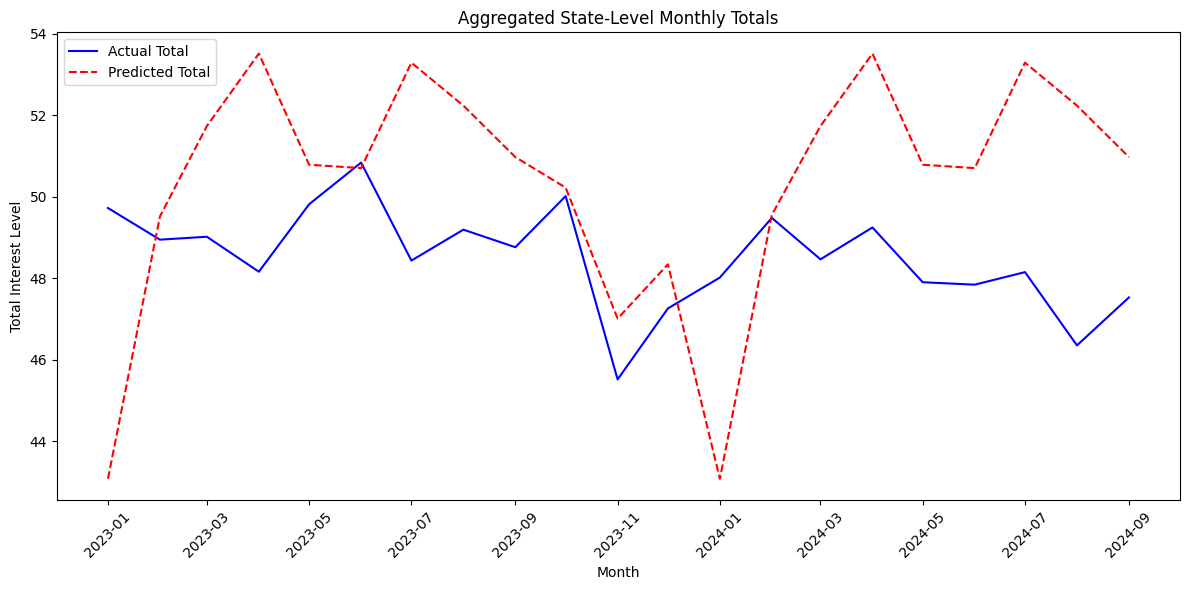

In [ ]:
# convert date column to datetime
eval_df['date'] = pd.to_datetime(eval_df['date'])

# aggregate date by monthly totals
monthly_totals = eval_df.groupby(eval_df['date'].dt.to_period('M')).agg(
    actual_total=('value', 'mean'),
    predicted_total=('predictions', 'mean')
).reset_index()

# convert date back to standard
monthly_totals['date'] = monthly_totals['date'].dt.to_timestamp()

# plot until september since october is not a full month of data
end_date = pd.Timestamp('2024-09-30')
monthly_totals = monthly_totals[monthly_totals['date'] <= end_date]

plt.figure(figsize=(12, 6))
plt.plot(monthly_totals['date'], monthly_totals['actual_total'], label='Actual Total', color='blue')
plt.plot(monthly_totals['date'], monthly_totals['predicted_total'], label='Predicted Total', color='red', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Total Interest Level')
plt.title('Aggregated State-Level Monthly Averages')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# generate dates for next year
future_dates = pd.date_range(start='2024-12-1', end='2025-11-30', freq='D')

all_states_predictions = pd.DataFrame()

regions = [col for col in X_train.columns if col.startswith('region_code_')]
for region in regions:
    future_X = pd.DataFrame({
        'year': future_dates.year,
        'month': future_dates.month,
        'day': future_dates.day
    })

    # one-hot encode region columns
    for reg in regions:
        future_X[reg] = 0

    # set current region to 1
    future_X[region] = 1

    # set search columns for alcohol and marijuana (using average values)
    future_X['search_Marijuana'] = X_train['search_Marijuana'].mean()
    future_X['search_Alcohol'] = X_train['search_Alcohol'].mean()
    future_X = future_X[X_train.columns]

    # daily predictions for the next year
    daily_predictions = rf_model.predict(future_X)
    state_predictions = pd.DataFrame({
        'date': future_dates,
        'predicted_value': daily_predictions,
        'region': region
    })

    all_states_predictions = pd.concat([all_states_predictions, state_predictions], ignore_index=True)

# group by region and month, and calculate mean predictions
all_states_predictions['month'] = all_states_predictions['date'].dt.to_period('M')
monthly_predictions = all_states_predictions.groupby(['region', 'month'])['predicted_value'].mean().reset_index()

monthly_predictions['month'] = monthly_predictions['month'].astype(str)

monthly_predictions.to_csv('monthly_predictions_all_states.csv', index=False)


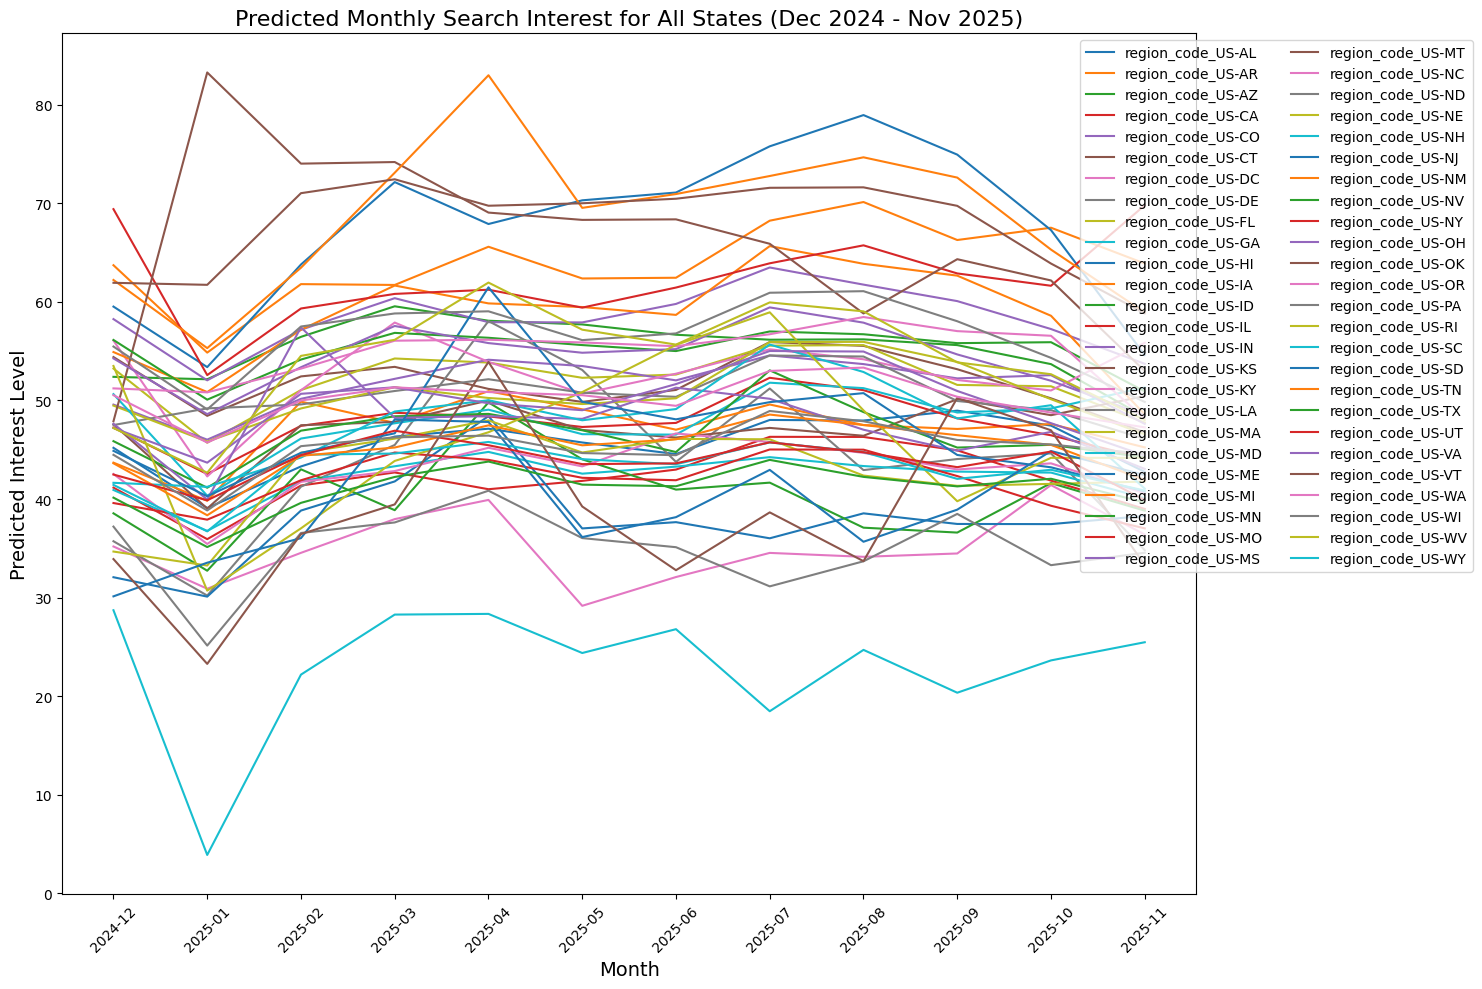

In [ ]:
# plot predictions for all states
plt.figure(figsize=(15, 10))

for region in regions:
    state_data = monthly_predictions[monthly_predictions['region'] == region]
    plt.plot(state_data['month'], state_data['predicted_value'], label=region)

plt.title('Predicted Monthly Search Interest for All States (Dec 2024 - Nov 2025)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Predicted Interest Level', fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), fontsize=10, ncol=2)  # Adjust legend position
plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# output directory
output_dir = 'state_predictions_graphs'
os.makedirs(output_dir, exist_ok=True)

# group by region and month, and calculate mean predictions
all_states_predictions['month'] = all_states_predictions['date'].dt.to_period('M')
monthly_predictions = all_states_predictions.groupby(['region', 'month'])['predicted_value'].mean().reset_index()

monthly_predictions['month'] = monthly_predictions['month'].astype(str)

for region in regions:
    state_data = monthly_predictions[monthly_predictions['region'] == region]

    # plot predictions for the current state
    plt.figure(figsize=(10, 6))
    plt.plot(state_data['month'], state_data['predicted_value'], label=f'Predicted Interest for {region}', color='blue')

    plt.title(f'Predicted Monthly Search Interest for {region} (Dec 2024 - Nov 2025)', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Predicted Interest Level', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(loc='upper left', fontsize=10)
    plt.tight_layout()

    # save graphs as pictures per state
    graph_path = os.path.join(output_dir, f'{region}_predictions.png')
    plt.savefig(graph_path)
    plt.close()

    print(f"Graph for {region} saved at {graph_path}")

print(f"All graphs saved in the directory: {output_dir}")

Graph for region_code_US-AL saved at state_predictions_graphs/region_code_US-AL_predictions.png
Graph for region_code_US-AR saved at state_predictions_graphs/region_code_US-AR_predictions.png
Graph for region_code_US-AZ saved at state_predictions_graphs/region_code_US-AZ_predictions.png
Graph for region_code_US-CA saved at state_predictions_graphs/region_code_US-CA_predictions.png
Graph for region_code_US-CO saved at state_predictions_graphs/region_code_US-CO_predictions.png
Graph for region_code_US-CT saved at state_predictions_graphs/region_code_US-CT_predictions.png
Graph for region_code_US-DC saved at state_predictions_graphs/region_code_US-DC_predictions.png
Graph for region_code_US-DE saved at state_predictions_graphs/region_code_US-DE_predictions.png
Graph for region_code_US-FL saved at state_predictions_graphs/region_code_US-FL_predictions.png
Graph for region_code_US-GA saved at state_predictions_graphs/region_code_US-GA_predictions.png
Graph for region_code_US-HI saved at sta

In [ ]:
# make predictions for daily values
daily_predictions = rf_model.predict(future_X)

# combine the predicted values with the future dates
daily_predictions_df = pd.DataFrame({
    'date': future_dates,
    'predicted_value': daily_predictions
})

daily_predictions_df.to_csv('daily_predictions.csv', index=False)

print(daily_predictions_df)

          date  predicted_value
0   2024-12-01            35.37
1   2024-12-02            41.40
2   2024-12-03            36.95
3   2024-12-04            42.37
4   2024-12-05            38.59
..         ...              ...
360 2025-11-26            46.05
361 2025-11-27            44.63
362 2025-11-28            44.77
363 2025-11-29            39.79
364 2025-11-30            34.64

[365 rows x 2 columns]


In [ ]:
# group by month and sum the predicted values to get monthly totals
daily_predictions_df['month'] = daily_predictions_df['date'].dt.to_period('M')
monthly_predictions_df = daily_predictions_df.groupby('month')['predicted_value'].mean().reset_index()

monthly_predictions_df['month'] = monthly_predictions_df['month'].astype(str)

monthly_predictions_df.to_csv('monthly_predictions.csv', index=False)

print(monthly_predictions_df)

      month  predicted_value
0   2024-12        41.158387
1   2025-01        35.928710
2   2025-02        41.373929
3   2025-03        42.698387
4   2025-04        40.997667
5   2025-05        41.841935
6   2025-06        42.989667
7   2025-07        46.312581
8   2025-08        46.301290
9   2025-09        44.942000
10  2025-10        41.867742
11  2025-11        38.995000


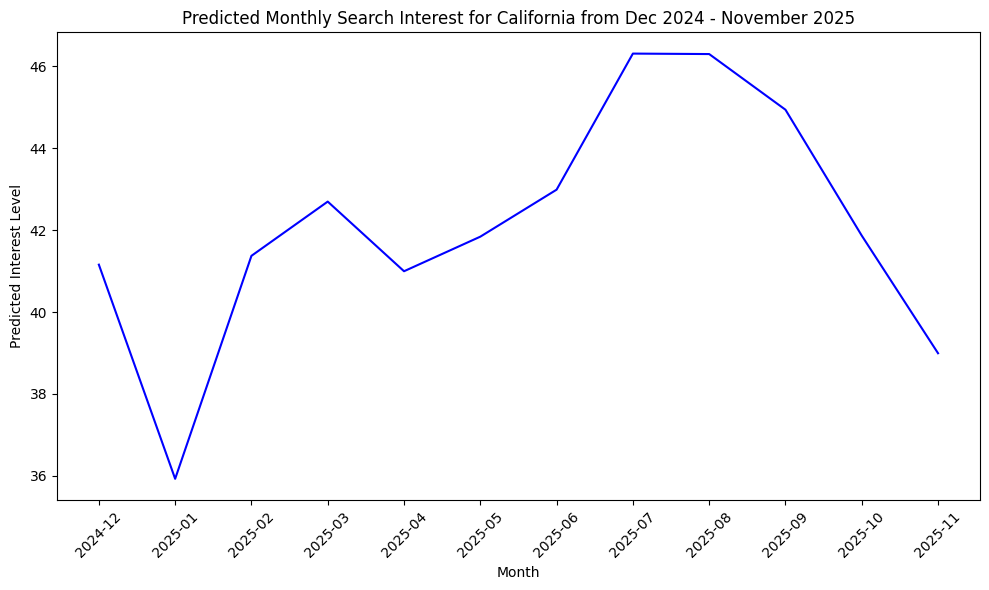

In [ ]:
# plot monthly predictions
plt.figure(figsize=(10, 6))
plt.plot(monthly_predictions_df['month'], monthly_predictions_df['predicted_value'], label='Predicted Monthly Interest', color='blue')

plt.title('Predicted Monthly Search Interest for California from Dec 2024 - November 2025')
plt.xlabel('Month')
plt.ylabel('Predicted Interest Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()